In [10]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [24]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',  # Prioridad en la detección
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Cargar el archivo metadata
metadata_path = "D:/dataverse_files/HAM10000_metadata.csv"
metadata_df = pd.read_csv(metadata_path)

In [18]:
from glob import glob
# Agregar las rutas a las imágenes
base_skin_dir = "D:/dataverse_files/"

# Dictionary mapping image_id to its full path
image_paths = {os.path.splitext(os.path.basename(x))[0]: x
               for x in glob(os.path.join(base_skin_dir, 'HAM10000_images_part_*', '*.jpg'), recursive=True)}

# Agregar la ruta a cada imagen en el DataFrame
metadata_df['path'] = metadata_df['image_id'].map(image_paths.get)
metadata_df['cell_type'] = metadata_df['dx'].map(lesion_type_dict.get)
metadata_df['cell_type_idx'] = pd.Categorical(metadata_df['cell_type']).codes

# Priorizar melanoma al duplicar imágenes de melanoma (opcional)
melanoma_df = metadata_df[metadata_df['dx'] == 'mel']
metadata_df = pd.concat([metadata_df, melanoma_df], ignore_index=True)



# Mostrar el DataFrame actualizado
metadata_df.sample(5)



lesion_id      image_id   dx dx_type   age     sex     localization  \
20483  HAM_0000002  ISIC_0034246  mel   histo  65.0  female  lower extremity   
62595  HAM_0006445  ISIC_0034120  mel   histo  60.0  female  lower extremity   
7272   HAM_0005127  ISIC_0028436   nv   histo  55.0  female            chest   
38142  HAM_0007343  ISIC_0033655  mel   histo  70.0    male            chest   
28165  HAM_0000611  ISIC_0033804  mel   histo  30.0  female             back   

                                                    path         cell_type  \
20483  D:/dataverse_files\HAM10000_images_part_2\ISIC...          Melanoma   
62595  D:/dataverse_files\HAM10000_images_part_2\ISIC...          Melanoma   
7272   D:/dataverse_files\HAM10000_images_part_1\ISIC...  Melanocytic nevi   
38142  D:/dataverse_files\HAM10000_images_part_2\ISIC...          Melanoma   
28165  D:/dataverse_files\HAM10000_images_part_2\ISIC...          Melanoma   

       cell_type_idx  
20483              5  
62595              5  
7272               4  
38142              5  
28165              5

In [20]:
# Loading the metadata
metadata_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  D:/dataverse_files\HAM10000_images_part_1\ISIC...   
1  D:/dataverse_files\HAM10000_images_part_1\ISIC...   
2  D:/dataverse_files\HAM10000_images_part_1\ISIC...   
3  D:/dataverse_files\HAM10000_images_part_1\ISIC...   
4  D:/dataverse_files\HAM10000_images_part_2\ISIC...   

                       cell_type  cell_type_idx  
0  Benign keratosis-like lesions              2  
1  Benign keratosis-like lesions              2  
2  Benign keratosis-like lesions              2  
3  Benign keratosis-like lesions              2  
4  Benign keratosis-like lesions              2

In [21]:

# Check for null values
metadata_df.isnull().sum()

lesion_id          0
image_id           0
dx                 0
dx_type            0
age              183
sex                0
localization       0
path               0
cell_type          0
cell_type_idx      0
dtype: int64

In [22]:
metadata_df['age'].fillna(metadata_df['age'].mean(), inplace=True)

metadata_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

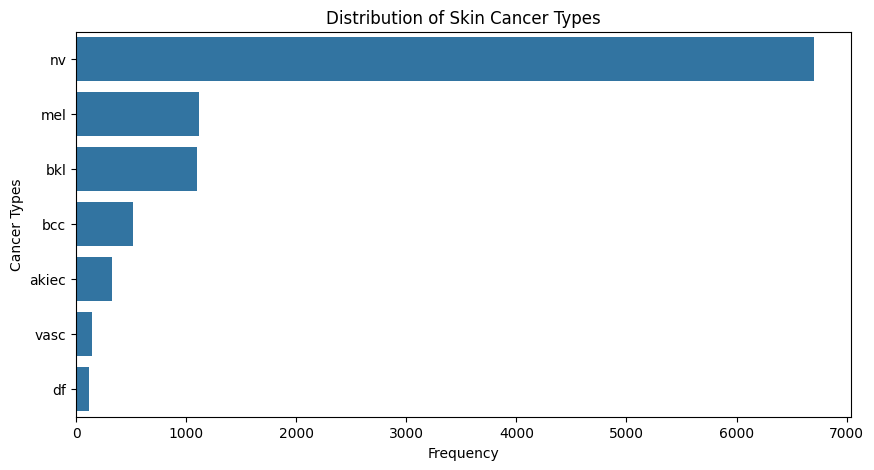

In [25]:
plt.figure(figsize=(10, 5))
sns.countplot(y=metadata_df['dx'], order = metadata_df['dx'].value_counts().index)
plt.title('Distribution of Skin Cancer Types')
plt.xlabel('Frequency')
plt.ylabel('Cancer Types')
plt.show()

<Axes: xlabel='localization'>

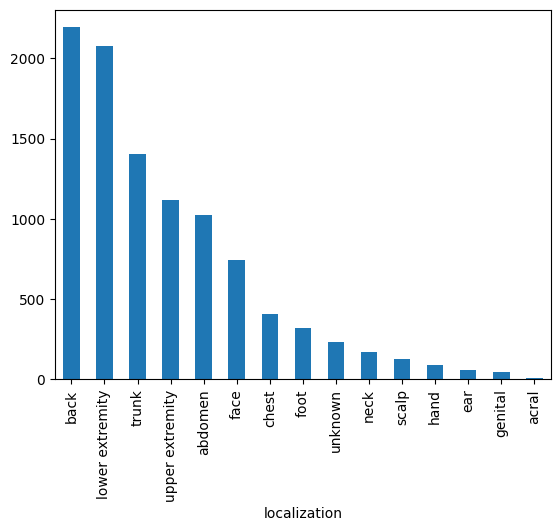

In [26]:
metadata_df['localization'].value_counts().plot(kind='bar')

<Axes: xlabel='age'>

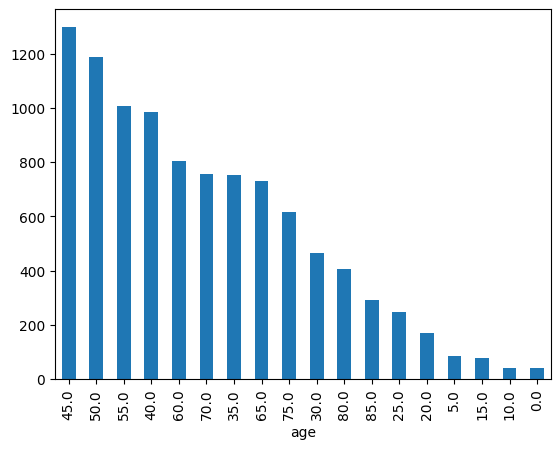

In [27]:
metadata_df['age'].value_counts().plot(kind='bar')

<Axes: xlabel='sex'>

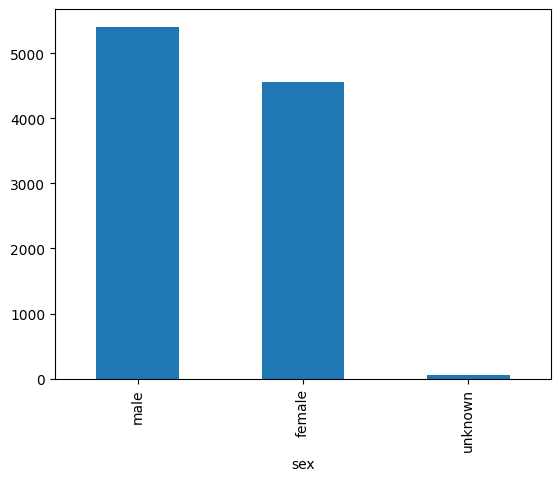

In [28]:
metadata_df['sex'].value_counts().plot(kind='bar')

In [30]:

from sklearn.preprocessing import LabelEncoder
print("Unique Cancer types represented in data.")
print(metadata_df.dx.unique(),"\n")

# Handling categorical data
encoder = LabelEncoder()
metadata_df["dx_label"] = encoder.fit_transform(metadata_df["dx"])

# Display of labels and their integer encoding
print("Cancer types and their integer encoding")
print(encoder.classes_)
print(encoder.transform(encoder.classes_))

Unique Cancer types represented in data.
['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec'] 

Cancer types and their integer encoding
['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
[0 1 2 3 4 5 6]


In [34]:
import os
import shutil
import pandas as pd

# Directorios de imágenes originales
images_dir_1 = r"D:\dataverse_files\HAM10000_images_part_1"
images_dir_2 = r"D:\dataverse_files\HAM10000_images_part_2"

# Directorio de destino para las imágenes organizadas
train_images_dir = r"D:\dataverse_files\train_images"  # Cambia esta ruta según tu preferencia

# Asumiendo que tienes un DataFrame 'metadata_df' con las columnas 'image_id' y 'dx_label'
# 'image_id' es el nombre de la imagen (sin extensión) y 'dx_label' es la clase de la imagen

# Crear directorios para cada clase
dir_names = metadata_df['dx_label'].unique()  # Lista de nombres de clases únicas
os.makedirs(train_images_dir, exist_ok=True)  # Crear la carpeta raíz si no existe

# Función para crear directorios según las clases
def create_dirs(dir_path, dir_names):
    for dir_name in dir_names:
        try:
            os.makedirs(os.path.join(dir_path, str(dir_name)))
        except FileExistsError:
            continue

# Crear directorios por clase
create_dirs(train_images_dir, dir_names)

# Función para mover imágenes
def move_images(src_dirs, dest_dir, metadata_df):
    for src_dir in src_dirs:
        for image in os.scandir(src_dir):
            try:
                # Obtener el nombre de la imagen sin la extensión
                img_name = image.name.split(".")[0]

                # Obtener la etiqueta de la imagen
                img_cancer_type = str(metadata_df.dx_label[metadata_df.image_id == img_name].item())

                # Copiar la imagen a la carpeta correspondiente
                shutil.copy(os.path.join(src_dir, image.name), os.path.join(dest_dir, img_cancer_type, image.name))
            except Exception as e:
                print(f"Error con la imagen {image.name}: {e}")

# Unificar ambas carpetas en una lista
image_dirs = [images_dir_1, images_dir_2]

# Mover imágenes desde ambas carpetas a la estructura organizada
move_images(image_dirs, train_images_dir, metadata_df)


In [40]:
print(metadata_df.columns)

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'dx_label'],
      dtype='object')


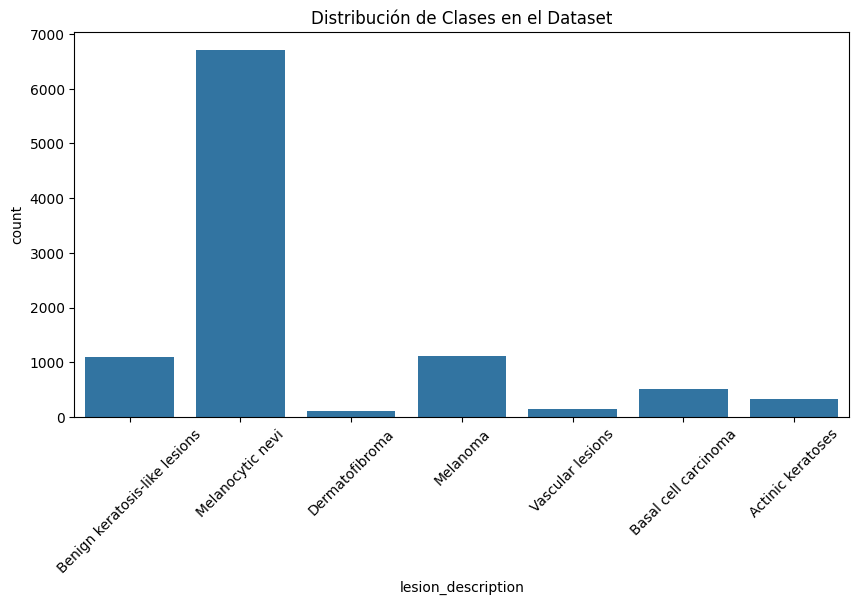

In [70]:
label_dict = label_dict = {
    0: 'akiec',
    1: 'bcc',
    2: 'bkl',
    3: 'df',
    4: 'mel',
    5: 'nv',
    6: 'vasc'
}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',  # Prioridad en la detección
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

metadata_df['lesion_abbr'] = metadata_df['dx_label'].map(label_dict)

# Si deseas obtener la descripción completa de las lesiones
metadata_df['lesion_description'] = metadata_df['lesion_abbr'].map(lesion_type_dict)

# Visualización de la distribución de las clases con los nombres de las clases
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x='lesion_description', data=metadata_df, ax=ax)
ax.set_title('Distribución de Clases en el Dataset')
plt.xticks(rotation=45)
plt.show()



In [78]:
import os
import shutil
from sklearn.preprocessing import LabelEncoder

# Directories
train_images_dir = r"D:/dataverse_files/train_images"
test_images_dir = r"D:/dataverse_files/validation"

# Labels: Assuming you have already assigned categories from 0 to 6
# Make sure the dir_names matches the category names used in train_images_dir (0 to 6)
dir_names = ['0', '1', '2', '3', '4', '5', '6']

# Encoder to convert category numbers to cancer types (if applicable)
# Replace this with the appropriate cancer type names if you need.
encoder = LabelEncoder()
encoder.fit(dir_names)  # Ensure the encoder is fitted with your categories

# List to store image categories from file paths
inds = [] 
twenty_percent_content = {}  # Dictionary to hold 20% count per category

# Count how many images exist in each category
for dir_name in os.scandir(train_images_dir):
    if dir_name.is_dir():
        for cancer_img in os.scandir(dir_name):
            if cancer_img.is_file():
                inds.append(cancer_img.path.split(os.sep)[-2])  # Using os.sep to handle OS-specific paths

# Calculate total and 20% for each category
for directory in dir_names:
    total_amt = inds.count(str(directory))
    print(f"There are {total_amt} images of category {directory}.")
    print(f"20% of category {directory} images is: {round(total_amt * 0.20)}\n")
    twenty_percent_content[directory] = round(total_amt * 0.20)

# Create directories for validation set if they don't exist
for dir_name in dir_names:
    os.makedirs(os.path.join(test_images_dir, dir_name), exist_ok=True)

# Move 20% of each type to the validation folder
for sub_dir in os.scandir(train_images_dir):
    if sub_dir.is_dir() and sub_dir.name in dir_names:
        images_paths = [image.path for image in os.scandir(sub_dir.path) if image.is_file()]
        # Move 20% of images
        for image_path in images_paths[:int(twenty_percent_content[sub_dir.name])]:
            # Define new path in validation folder
            dest_path = os.path.join(test_images_dir, sub_dir.name, os.path.basename(image_path))
            # Move the image to the validation folder
            shutil.move(image_path, dest_path)


There are 327 images of category 0.
20% of category 0 images is: 65

There are 514 images of category 1.
20% of category 1 images is: 103

There are 1099 images of category 2.
20% of category 2 images is: 220

There are 115 images of category 3.
20% of category 3 images is: 23

There are 1113 images of category 4.
20% of category 4 images is: 223

There are 6705 images of category 5.
20% of category 5 images is: 1341

There are 142 images of category 6.
20% of category 6 images is: 28



Total de muestras: 20


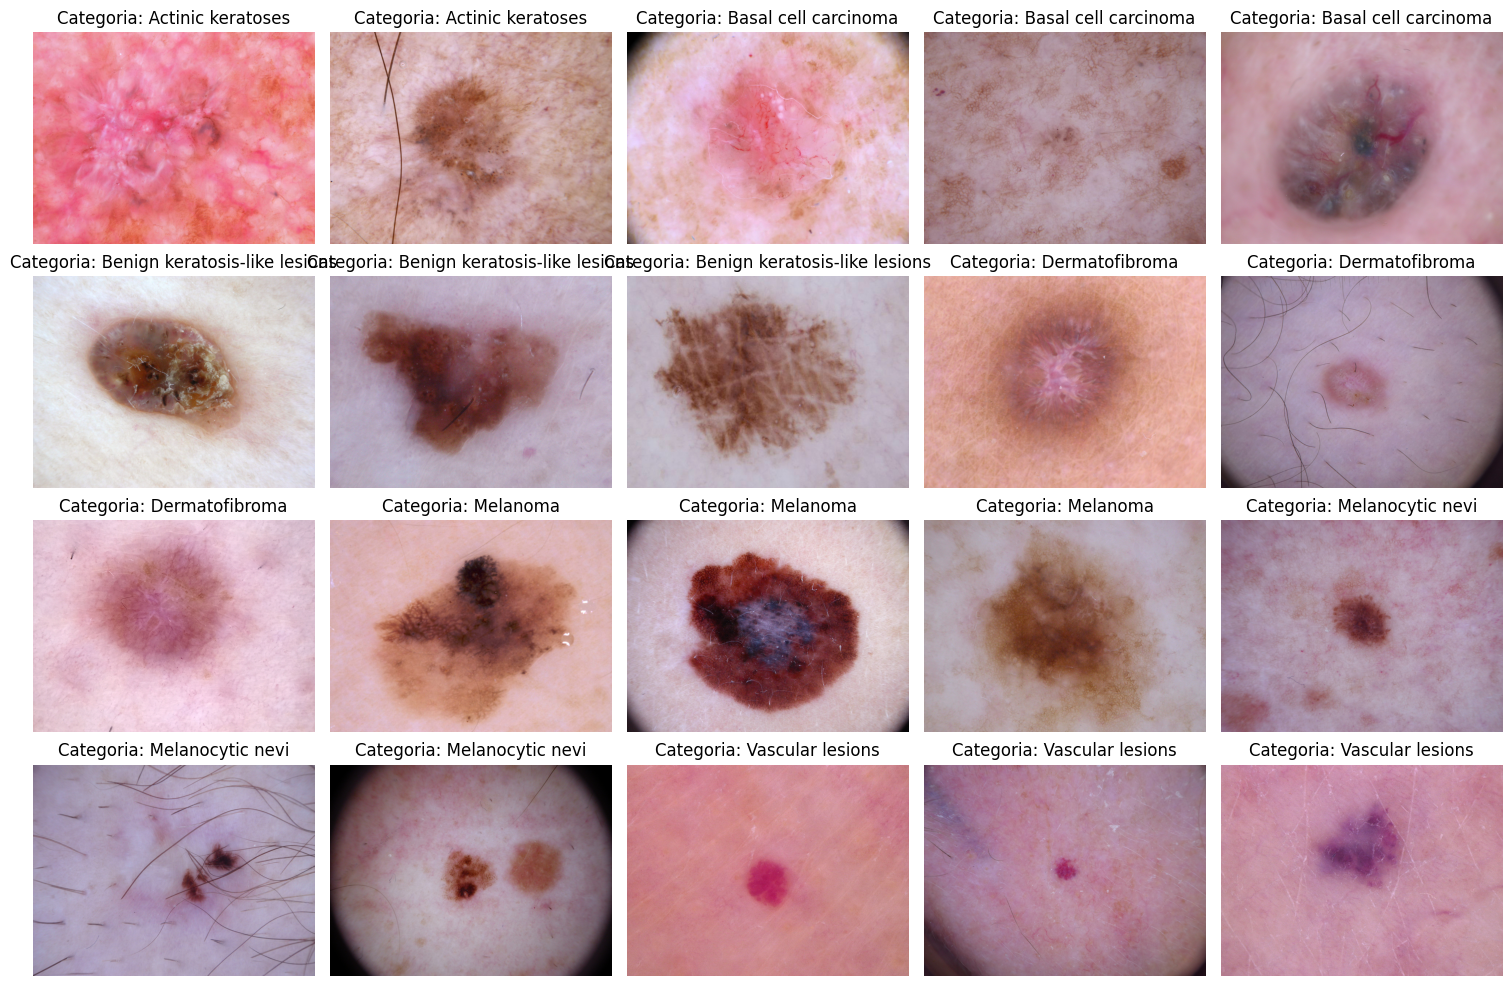

In [71]:
import random
import cv2


# Número de imágenes por categoría (5 para la primera categoría, 3 para las demás)
images_per_category = {0: 2}  # Para la categoría 0 (primera categoría), 5 imágenes
for i in range(1, 7):  # Para las demás categorías (1 a 6), 3 imágenes
    images_per_category[i] = 3

# Listas para almacenar imágenes y categorías
image_sample = []  # Contendrá las imágenes
image_sample_category = []  # Contendrá las categorías

# Recorrer cada categoría de imágenes (asumiendo que las categorías son carpetas numeradas)
for category in range(7):  # 6 categorías, de 0 a 6
    category_dir = os.path.join(train_images_dir, str(category))
    
    # Si la carpeta de la categoría existe
    if os.path.isdir(category_dir):
        images_paths = [image.path for image in os.scandir(category_dir)]
        
        # Seleccionar imágenes aleatorias de la categoría según el número especificado
        selected_images = random.sample(images_paths, min(images_per_category[category], len(images_paths)))
        
        # Cargar las imágenes y las categorías
        for image_path in selected_images:
            image_data = cv2.imread(image_path)[:,:,::-1]  # Leer la imagen y convertir de BGR a RGB
            image_sample.append(image_data)  # Añadir la imagen a la lista
            image_sample_category.append(label_dict[category])  # Añadir las siglas de la categoría

# Mostrar el número total de muestras
print(f"Total de muestras: {len(image_sample)}")

# Graficar las imágenes con los nombres completos de las lesiones
plt.figure(figsize=(15, 10))
for num in range(0, len(image_sample)):
    plt.subplot(4, 5, num + 1)  # Ajustar el número de subgráficas
    plt.axis(False)
    
    # Reemplazar las siglas por el nombre completo de la lesión
    category_name = lesion_type_dict[image_sample_category[num]]
    
    plt.title(f"Categoria: {category_name}")
    plt.imshow(image_sample[num])

plt.tight_layout()
plt.show()


In [79]:

from tensorflow.keras.utils import image_dataset_from_directory
img_size = 250 # Augmented image size.
batch_size = 32

generator = ImageDataGenerator(zoom_range = 0.3,
                               rotation_range = 90,
                               horizontal_flip = True,
                               vertical_flip = True,
                               validation_split = 0.1,)

# Augmented training set
augmented_train_data = generator.flow_from_directory(
                            train_images_dir,
                            target_size = (img_size, img_size),
                            batch_size = batch_size,
                            subset = "training")

# Un-augmented test set
unaugmented_validation_data = generator.flow_from_directory(
                            train_images_dir,
                            target_size = (img_size, img_size),
                            batch_size = 32,
                            subset = "validation")

# Un-augmented dev set.
unaugmented_test_data = image_dataset_from_directory(
                            test_images_dir,
                            image_size = (img_size, img_size),
                            batch_size = batch_size)

Found 7213 images belonging to 7 classes.
Found 799 images belonging to 7 classes.
Found 2003 files belonging to 7 classes.


In [85]:
from keras.applications import ResNet50
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential

# Load pre-trained ResNet50 model without the top (classification) layer
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

# Freeze the weights of the ResNet50 layers so that they are not trained
for layer in resnet_model.layers:
    layer.trainable = False

# Defining model architecture
model = Sequential()

# Add the ResNet50 model as the first layer
model.add(resnet_model)

# Layer one
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = (3,3), input_shape= (250, 250, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

# Layer two
model.add(Conv2D(32, kernel_size = (3,3)))
model.add(Activation("relu"))

# Layer three
model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))

# Layer four
model.add(Flatten())
model.add(Dense(32))
model.add(Activation("relu"))

# Layer five
model.add(Dense(7))
model.add(Activation("softmax"))

# Callbacks for improved training
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
]

# Compile the model
model.compile(
    loss = "categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"],
)

# Train the model using the `fit` method
history = model.fit(
    augmented_train_data,
    validation_data=unaugmented_validation_data,
    epochs=15,
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 2199s 9s/step - accuracy: 0.6571 - loss: 1.0366 - val_accuracy: 0.7334 - val_loss: 0.7416 - learning_rate: 0.0010
Epoch 2/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 1940s 9s/step - accuracy: 0.7221 - loss: 0.7830 - val_accuracy: 0.7472 - val_loss: 0.7071 - learning_rate: 0.0010
Epoch 3/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 1946s 9s/step - accuracy: 0.7460 - loss: 0.7169 - val_accuracy: 0.7347 - val_loss: 0.7302 - learning_rate: 0.0010
Epoch 4/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 1975s 9s/step - accuracy: 0.7531 - loss: 0.6913 - val_accuracy: 0.7597 - val_loss: 0.6835 - learning_rate: 0.0010
Epoch 5/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 1958s 9s/step - accuracy: 0.7748 - loss: 0.6344 - val_accuracy: 0.7622 - val_loss: 0.6814 - learning_rate: 0.0010
Epoch 6/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 1977s 9s/step - accuracy: 0.7798 - loss: 0.6320 - val_accuracy: 0.7822 - val_loss: 0.6222 - learning_rate: 0.0010
Epoch 7/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 1918s 8s/step - accuracy: 0.7937 - l

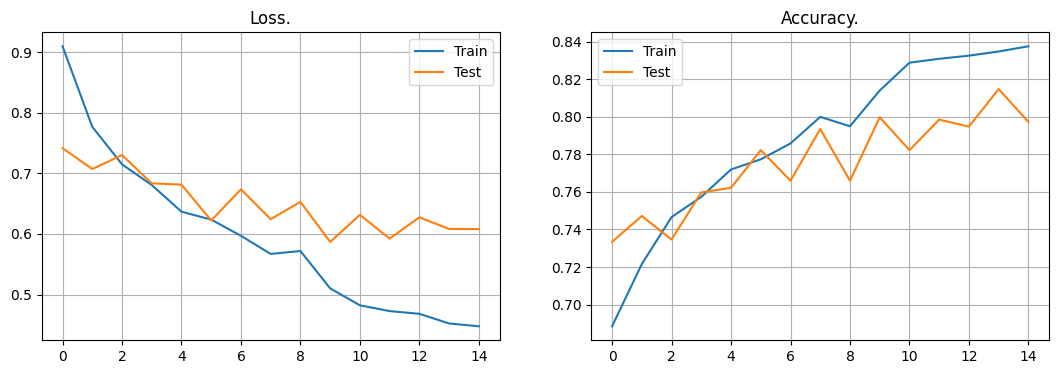

In [86]:
metrics = history.history

train_loss = metrics["loss"]
train_accuracy = metrics["accuracy"]

test_loss = metrics["val_loss"]
test_accuracy = metrics["val_accuracy"]

# Visualizing metrics
plt.figure(figsize = (13,4))
plt.subplot(1,2,1)
plt.title("Loss.")
plt.plot(train_loss, label = "Train")
plt.plot(test_loss, label = "Test")
plt.grid(True)
plt.legend(loc = "best")

plt.subplot(1,2,2)
plt.title("Accuracy.")
plt.plot(train_accuracy, label = "Train")
plt.plot(test_accuracy, label = "Test")
plt.grid(True)
plt.legend(loc = "best")

In [87]:
result = model.predict(unaugmented_test_data)

63/63 ━━━━━━━━━━━━━━━━━━━━ 515s 7s/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 819s 8s/step


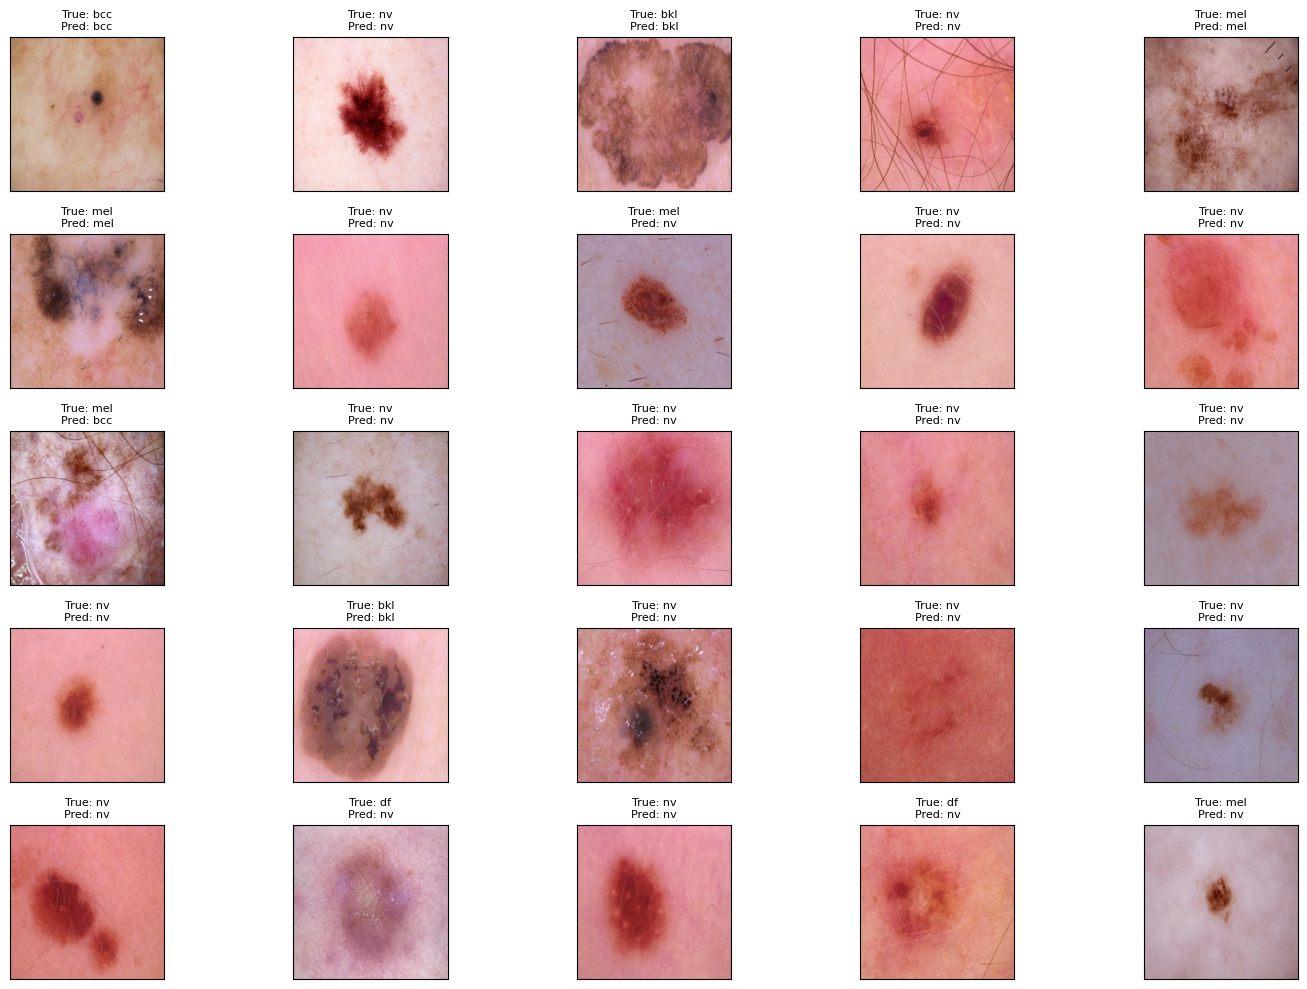

In [88]:
# Initialize empty lists to store test data and true labels
X_test = []
true_class = []
for images, labels in unaugmented_test_data.take(-1):  # take(-1) to take all batches
    for i in range(images.shape[0]):
        X_test.append(images[i].numpy())  # Convert tensor to numpy array
        true_class.append(labels[i].numpy())  # Convert labels to numpy array

# Convert lists to numpy arrays for easier indexing later
X_test = np.array(X_test)
true_class = np.array(true_class)

# Predict on test data
result = model.predict(X_test)
predicted_class = [predicted_label.argmax() for predicted_label in result]

label_dict = label_dict = {
    0: 'akiec',
    1: 'bcc',
    2: 'bkl',
    3: 'df',
    4: 'mel',
    5: 'nv',
    6: 'vasc'
}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',  # Prioridad en la detección
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

def plot_images(images, true_labels, predicted_labels):
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(5, 5, i+1)
        img = images[i]
        if img.max() > 1:
            img = img / 255.0  # Normalize
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        true_label = label_dict[true_labels[i]]
        predicted_label = label_dict[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=8)
        if i == 24:  # Only display the first 25 images
            break
    plt.tight_layout()
    plt.show()
    
# Plot test images along with the true and predicted labels
plot_images(X_test, true_class, predicted_class)

Text(0.5, 23.52222222222222, 'Predicted Class')

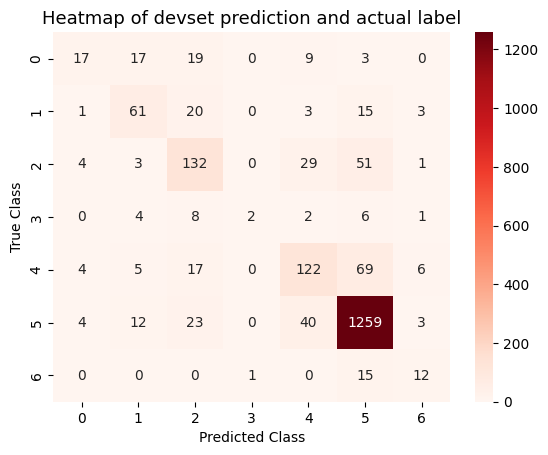

In [90]:

# Calculating confusion matrix
plt.title("Heatmap of devset prediction and actual label", fontsize = 13)
cm = confusion_matrix(true_class, predicted_class)
sns.heatmap(cm, cmap = "Reds", annot = True, fmt = "d")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
     

In [91]:

# Understanding classification power of model on each class
report = classification_report(true_class, predicted_class)
print(report)

              precision    recall  f1-score   support

           0       0.57      0.26      0.36        65
           1       0.60      0.59      0.60       103
           2       0.60      0.60      0.60       220
           3       0.67      0.09      0.15        23
           4       0.60      0.55      0.57       223
           5       0.89      0.94      0.91      1341
           6       0.46      0.43      0.44        28

    accuracy                           0.80      2003
   macro avg       0.63      0.49      0.52      2003
weighted avg       0.79      0.80      0.79      2003



In [89]:
# Configuración para el preprocesamiento de imágenes
img_size = (128, 128)
batch_size = 32

# Generador de datos para imágenes
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # Dividir en conjunto de entrenamiento y validación
)

# Crear generadores de datos
train_generator = datagen.flow_from_dataframe(
    metadata_df,
    directory=None,
    x_col='path',
    y_col='cell_type',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    metadata_df,
    directory=None,
    x_col='path',
    y_col='cell_type',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation'
)


KeyError: 'path'

In [9]:
# Definición del modelo CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 clases
])

# Compilación del modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenamiento del modelo
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=30,
                    callbacks=[early_stop])


Epoch 1/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 1040s 4s/step - accuracy: 0.7299 - loss: 0.8742 - val_accuracy: 0.0404 - val_loss: 3.4075
Epoch 2/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 1094s 4s/step - accuracy: 0.7527 - loss: 0.6787 - val_accuracy: 8.9888e-04 - val_loss: 6.4131
Epoch 3/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 1000s 4s/step - accuracy: 0.7540 - loss: 0.6196 - val_accuracy: 0.0427 - val_loss: 4.3506
Epoch 4/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 994s 4s/step - accuracy: 0.7737 - loss: 0.5816 - val_accuracy: 0.0620 - val_loss: 5.5756
Epoch 5/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 564s 2s/step - accuracy: 0.7714 - loss: 0.5655 - val_accuracy: 0.0382 - val_loss: 4.6532
Epoch 6/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 549s 2s/step - accuracy: 0.7731 - loss: 0.5601 - val_accuracy: 0.0458 - val_loss: 5.4657


In [ ]:


# Obtener los nombres de las clases desde el generador de validación
target_names = list(validation_generator.class_indices.keys())

# Evaluación del modelo
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Precisión en validación: {val_acc * 100:.2f}%")

# Reporte de clasificación
preds = model.predict(validation_generator)
y_true = validation_generator.classes
y_pred = np.argmax(preds, axis=1)

print(classification_report(y_true, y_pred, target_names=target_names))

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.title('Matriz de Confusión')
plt.show()

NameError: name 'validation_generator' is not defined